In [10]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import astropy.units as u

#picaso
import picaso.opacity_factory as opa_fa
from picaso import justdoit as jdi
from picaso import justplotit as jpi

import virga.justdoit as vj
#plotting
from bokeh.io import output_notebook
from scipy.stats.stats import pearsonr

output_notebook()
from bokeh.plotting import show,figure

Loading BokehJS ...

In [11]:
wave_range = [1.00,1.3]

opa = jdi.opannection(wave_range=wave_range)

In [12]:
bd = jdi.inputs(calculation='brown')

bd.phase_angle(0)
bd.gravity(gravity=1000 , gravity_unit=u.Unit('m/s**2'))

sonora_profile_db = '/Users/sagnickmukherjee/Documents/software/sonora/profile/'
Teff = 1000
bd.sonora(sonora_profile_db, Teff)
pressure,temperature=bd.inputs['atmosphere']['profile']['pressure'],bd.inputs['atmosphere']['profile']['temperature']


In [13]:
df = bd.spectrum(opa,full_output=True)

In [14]:
print(df['full_output'].keys())

dict_keys(['weights', 'layer', 'wavenumber', 'wavenumber_unit', 'taugas', 'tauray', 'taucld', 'level', 'latitude', 'longitude', 'star', 'thermal_unit', 'thermal_3d'])


In [15]:
bd.inputs['planet']['radius'] = 7e9 #cm
print(pressure[89])
p_reference = pressure[89]


176.31


In [17]:
from picaso.atmsetup import ATMSETUP

atm = ATMSETUP(bd.inputs)

#Add inputs to class 
atm.wavenumber = df['wavenumber']
atm.planet.gravity = bd.inputs['planet']['gravity']
atm.planet.radius = bd.inputs['planet']['radius']
atm.planet.mass = bd.inputs['planet']['mass']


atm.get_profile()


#now can get these 
atm.get_mmw()
atm.get_density()
atm.get_altitude(p_reference = p_reference,constant_gravity=True)#will calculate altitude if r and m are given (opposed to just g)
atm.get_column_density()

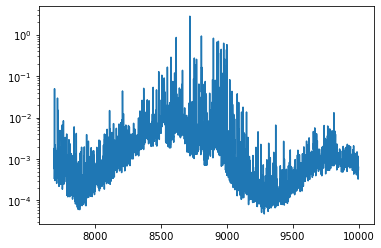

In [19]:
import matplotlib.pyplot as plt
plt.semilogy(df['wavenumber'],df['full_output']['taugas'][40,:]/atm.layer['colden'][40])

In [20]:
print(temperature[40],pressure[40])

556.5 0.08809700000000001


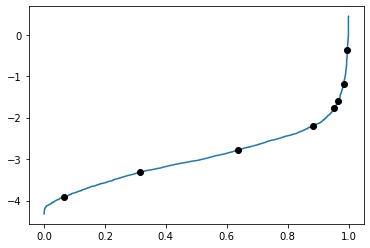

In [21]:
level_n = 40

gi = np.array([0.065960251992824,0.313509004297193,0.636490995702807,0.884039748007175,0.953471592210149,0.966500473910379,0.983499526089621,0.996528407789851])

kappa = df['full_output']['taugas'][level_n,:]/atm.layer['colden'][level_n]
N=len(kappa)

H,X1 = np.histogram( np.log10(kappa), bins = N, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx

plt.plot( F1,X1[1:])


from scipy.interpolate import UnivariateSpline,interp1d

#spl = UnivariateSpline(F1,X1[1:],k=5)
f2 = interp1d(F1,X1[1:])

plt.plot(gi,f2(gi),"ko")

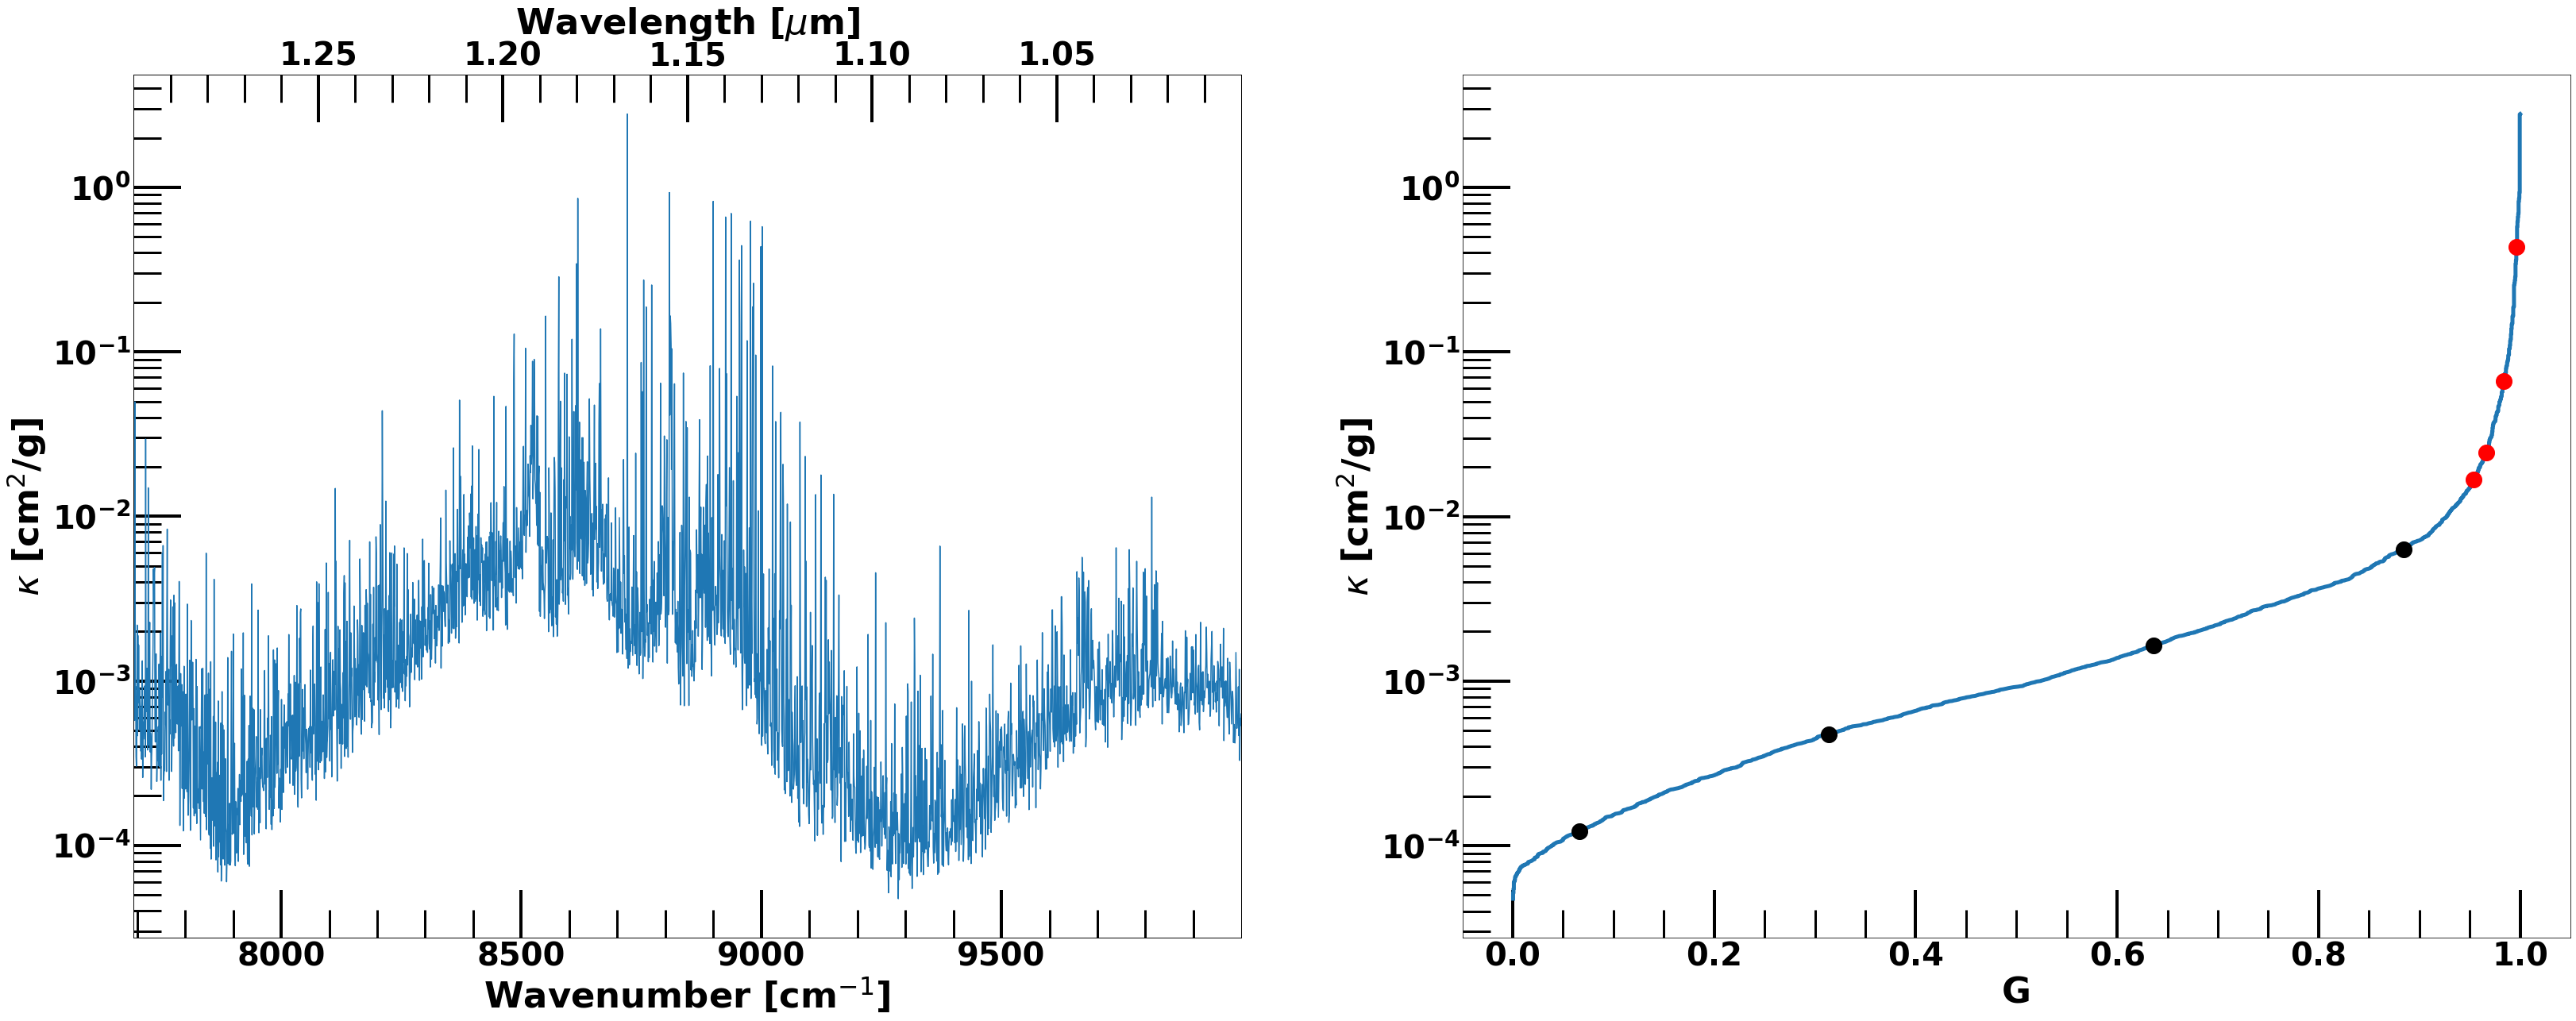

In [22]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(55,20))



ax[0].semilogy(df['wavenumber'],df['full_output']['taugas'][40,:]/atm.layer['colden'][40])



ax1= ax[0].twiny()

ax1.semilogy(1e4/df['wavenumber'],df['full_output']['taugas'][40,:]/atm.layer['colden'][40],alpha=0)

ax[0].set_xlim(np.min(df['wavenumber']),np.max(df['wavenumber']))
ax1.set_xlim(np.max(1e4/df['wavenumber']),np.min(1e4/df['wavenumber']))

ax[0].set_xlabel("Wavenumber [cm$^{-1}$]",fontsize=45)
ax[0].set_ylabel("$\kappa$ [cm$^2$/g]",fontsize=45)
ax1.set_xlabel("Wavelength [$\mu$m]",fontsize=45,labelpad=8)

ax[0].minorticks_on()
ax[0].tick_params(axis='both',which='major',color="k",length =60, width=4,direction='in',labelsize=40)
ax[0].tick_params(axis='both',which='minor',color="k",length =35, width=3,direction='in',labelsize=50)

ax1.minorticks_on()
ax1.tick_params(axis='both',which='major',color="k",length =60, width=4,direction='in',labelsize=40)
ax1.tick_params(axis='both',which='minor',color="k",length =35, width=3,direction='in',labelsize=50)


ax[1].semilogy( F1,10**X1[1:],linewidth=5)
ax[1].plot(gi[:4],10**f2(gi[:4]),"ko",markersize=20)
ax[1].plot(gi[4:],10**f2(gi[4:]),"ro",markersize=20)

ax[1].minorticks_on()
ax[1].tick_params(axis='both',which='major',color="k",length =60, width=4,direction='in',labelsize=40)
ax[1].tick_params(axis='both',which='minor',color="k",length =35, width=3,direction='in',labelsize=50)

ax[1].set_ylabel("$\kappa$ [cm$^2$/g]",fontsize=45)
ax[1].set_xlabel("G",fontsize=45)

plt.savefig("../../GitHub/picaso/benchmarking/k-coeff.pdf",bbox_inches="tight")